In [1]:
# Multicollinearity Analysis
#Libraries 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import os

plt.rcParams["figure.figsize"] = (12, 9)
sns.set(style="whitegrid")

In [26]:
#Dataset
## Tickers: S&P 500 ETF plus ten large components

tickers = ["^GSPC", "AAPL", "MSFT", "GOOG", "META", "AMZN","NVDA", "TSLA", "BRK-B", "JPM", "JNJ"]
start, end = "2010-01-01", "2025-09-01"

for t in tickers:
    df = yf.download(t, start=start, end=end, interval="3mo", progress=False)
    print("\nTicker:", t)
    print("Columns:", df.columns.tolist())
    print("Head:\n", df.head(2))



Ticker: ^GSPC
Columns: [('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]
Head:
 Price             Close         High          Low         Open        Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC
Date                                                                        
2010-01-01  1169.430054  1180.689941  1044.500000  1116.560059  279192470000
2010-04-01  1030.709961  1219.800049  1028.329956  1171.229980  354511440000

Ticker: AAPL
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Head:
 Price          Close      High       Low      Open       Volume
Ticker          AAPL      AAPL      AAPL      AAPL         AAPL
Date                                                           
2010-01-01  7.054727  7.129178  5.711327  6.407194  38099247200
2010-04-01  7.550961  8.375914  5.981509  7.127077  47101037200

Ticker: MSFT
Columns: [('Close', 'MSFT'), 

In [49]:
#Add SPY and XLK quarterly returns to our DataFrame
for etf in ["SPY", "XLK"]:
    df = yf.download(etf, start="2010-01-01", end="2025-09-01",
                     interval="3mo", progress=False)
    print("\nTicker:", t)
    print("Columns:", df.columns.tolist())
    print("Head:\n", df.head(2))



Ticker: JNJ
Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Head:
 Price           Close       High        Low       Open       Volume
Ticker            SPY        SPY        SPY        SPY          SPY
Date                                                               
2010-01-01  88.040848  88.921255  78.694975  84.556840  12058443200
2010-04-01  77.991447  92.271998  77.734546  89.007873  17007028100

Ticker: JNJ
Columns: [('Close', 'XLK'), ('High', 'XLK'), ('Low', 'XLK'), ('Open', 'XLK'), ('Volume', 'XLK')]
Head:
 Price           Close       High        Low       Open     Volume
Ticker            XLK        XLK        XLK        XLK        XLK
Date                                                             
2010-01-01  18.671961  18.898287  16.740099  18.704292  718489100
2010-04-01  16.542023  19.590945  16.493370  18.780061  822849300


In [50]:
#Quarterly Prices 

tickers = [ "^GSPC", "AAPL", "MSFT", "GOOG", "META", "AMZN","NVDA", "TSLA", "BRK-B", "JPM", "JNJ", "SPY", "XLK"]
start, end = "2010-01-01", "2025-09-01"

frames = []
for t in tickers:
    df = yf.download(t, start=start, end=end, interval="3mo", progress=False)
    col = next((c for c in ["Adj Close", "Close"] if c in df.columns), None)
    s = df[col].copy()
    s.name = t                 # set the Series name
    frames.append(s)

prices_q = pd.concat(frames, axis=1)
print("Quarterly prices:\n", prices_q.head())

Quarterly prices:
 Ticker            ^GSPC      AAPL       MSFT       GOOG  META    AMZN  \
Date                                                                    
2010-01-01  1169.430054  7.054727  21.930445  14.029052   NaN  6.7885   
2010-04-01  1030.709961  7.550961  17.308956  11.006886   NaN  5.4630   
2010-06-01          NaN       NaN        NaN        NaN   NaN     NaN   
2010-07-01  1141.199951  8.518209  18.505398  13.006658   NaN  7.8530   
2010-09-01          NaN       NaN        NaN        NaN   NaN     NaN   

Ticker          NVDA      TSLA      BRK-B        JPM        JNJ        SPY  \
Date                                                                         
2010-01-01  0.398845       NaN  81.269997  29.927181  41.002075  88.040848   
2010-04-01  0.234035       NaN  79.690002  24.512856  37.425018  77.991447   
2010-06-01       NaN  1.298667        NaN        NaN        NaN        NaN   
2010-07-01  0.267731       NaN  82.680000  25.512232  39.621323  86.645172   
2

In [51]:
# Quarterly simple returns
returns_q = prices_q.pct_change().dropna()

print("Quarterly returns:\n", returns_q.head())

Quarterly returns:
 Ticker         ^GSPC      AAPL      MSFT      GOOG      META      AMZN  \
Date                                                                     
2012-06-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-07-01  0.057636  0.142295 -0.020750  0.300705  0.000000  0.113729   
2012-08-01  0.000000  0.000000  0.000000  0.000000 -0.027637  0.000000   
2012-09-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-10-01 -0.010051 -0.198839 -0.096541 -0.062452  0.000000 -0.013566   

Ticker          NVDA      TSLA     BRK-B       JPM       JNJ       SPY  \
Date                                                                     
2012-06-01  0.000000 -0.033221  0.000000  0.000000  0.000000  0.000000   
2012-07-01 -0.034732  0.000000  0.058442  0.140357  0.029911  0.063306   
2012-08-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-09-01  0.000000  0.185835  0.000000  0.000000  0.000000  0.000000   
2012-10-01 -0.080

C:\Users\OkechPC\AppData\Local\Temp\ipykernel_38808\3376601740.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_q = prices_q.pct_change().dropna()


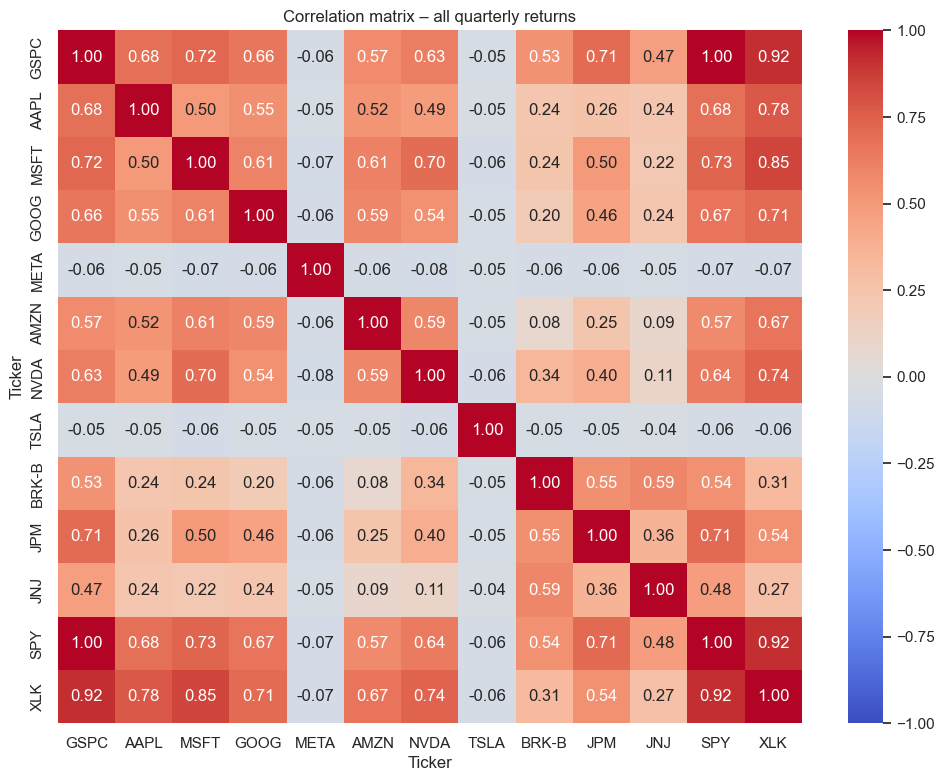

In [53]:
#S&P 500's quarterly return as the dependent variable and the others as predictors
#Rename the S&P 500 column

returns_q = returns_q.rename(columns={"^GSPC": "GSPC"})
y = returns_q["GSPC"]
X = returns_q[["AAPL", "MSFT", "GOOG", "META", "AMZN","NVDA", "TSLA", "BRK-B", "JPM", "JNJ", "SPY", "XLK"]]

#Correlation plot of all variables 

corr_all = returns_q.corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr_all, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1)
plt.title("Correlation matrix – all quarterly returns")
plt.show()

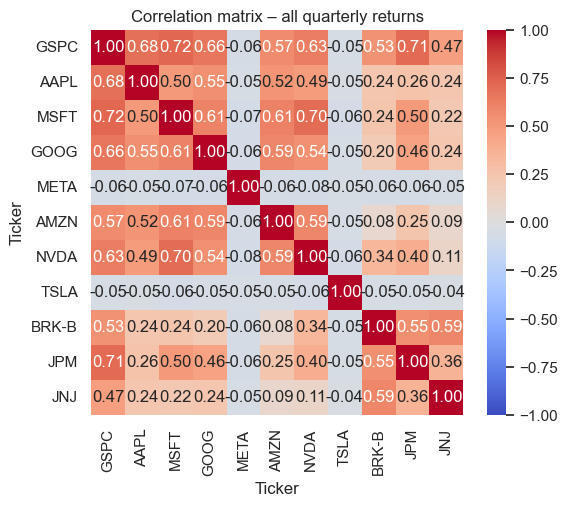

In [36]:
#S&P500's quarterly return as the dependent variable and the others as predictors

y = returns_q["GSPC"]
X = returns_q[["AAPL", "MSFT", "GOOG", "META", "AMZN","NVDA", "TSLA", "BRK-B", "JPM", "JNJ"]]

#Correlation plot of all variables 

corr_all = returns_q.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_all, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1)
plt.title("Correlation matrix – all quarterly returns")
plt.show()

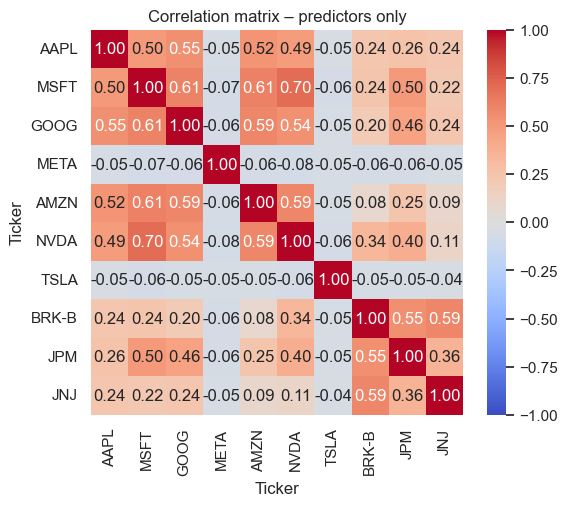

In [37]:
# Correlation plot of all independent variables

corr_predictors = X.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_predictors, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1)
plt.title("Correlation matrix – predictors only")
plt.show()


In [54]:
#S&P500 Excess Return Regression Model with Independent Variables

returns_q = returns_q.rename(columns={"BRK-B": "BRK_B"})

model_1 = smf.ols(
    formula="GSPC ~ AAPL + MSFT + GOOG + META + AMZN + NVDA + TSLA + BRK_B + JPM + JNJ + SPY + XLK",
    data=returns_q
).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   GSPC   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7313.
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          2.55e-196
Time:                        13:52:27   Log-Likelihood:                 781.32
No. Observations:                 159   AIC:                            -1537.
Df Residuals:                     146   BIC:                            -1497.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.000     -6.370      0.0

In [41]:
# Parameters with high precision
model_1.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-0.004045,0.001525,-2.652182,8.869392e-03,-0.007059,-0.001031
AAPL,0.148737,0.018724,7.943856,4.552458e-13,0.111737,0.185737
MSFT,0.126245,0.031951,3.951200,1.200054e-04,0.063106,0.189384
GOOG,0.038868,0.025373,1.531826,1.277001e-01,-0.011273,0.089008
META,0.007546,0.011127,0.678140,4.987419e-01,-0.014442,0.029533
AMZN,0.048658,0.021131,2.302652,2.269211e-02,0.006900,0.090415
NVDA,0.012014,0.012845,0.935314,3.511501e-01,-0.013370,0.037398
TSLA,0.002915,0.005016,0.581196,5.619926e-01,-0.006996,0.012826
BRK_B,0.083064,0.038901,2.135291,3.438333e-02,0.006192,0.159937
JPM,0.206532,0.025678,8.043155,2.593367e-13,0.155789,0.257274


In [55]:
# Regression model to check multicollinearity among independent variables

model_AAPL = smf.ols(
    formula="AAPL ~ MSFT + GOOG + META + AMZN + NVDA + TSLA + BRK_B + JPM + JNJ + SPY + XLK",
    data=returns_q
).fit()

print(model_AAPL.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     41.15
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           2.16e-39
Time:                        13:52:39   Log-Likelihood:                 262.97
No. Observations:                 159   AIC:                            -501.9
Df Residuals:                     147   BIC:                            -465.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0036      0.004      0.814      0.4

In [56]:
# Parameters with 6 significant digits
model_AAPL.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,0.003561,0.004377,0.813749,4.171047e-01,-0.005088,0.012211
MSFT,-0.828794,0.116618,-7.106916,4.762701e-11,-1.059258,-0.598329
GOOG,0.042588,0.072978,0.583572,5.604027e-01,-0.101634,0.186810
META,-0.006644,0.031616,-0.210134,8.338538e-01,-0.069125,0.055837
AMZN,0.067852,0.061252,1.107742,2.697827e-01,-0.053197,0.188900
NVDA,-0.103580,0.038677,-2.678061,8.247812e-03,-0.180016,-0.027145
TSLA,-0.002567,0.014249,-0.180128,8.573003e-01,-0.030725,0.025592
BRK_B,0.376202,0.121089,3.106822,2.270256e-03,0.136902,0.615502
JPM,-0.122129,0.091922,-1.328614,1.860342e-01,-0.303790,0.059531
JNJ,0.216453,0.123489,1.752808,8.171981e-02,-0.027591,0.460497


In [57]:
# Add a constant column for the intercept

import statsmodels.api as sm
X_with_const = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i)
              for i in range(X_with_const.shape[1])]

print(vif)

   Variable        VIF
0     const   1.320004
1      AAPL   4.079076
2      MSFT   6.096314
3      GOOG   2.232055
4      META   1.013497
5      AMZN   2.207639
6      NVDA   3.052805
7      TSLA   1.010518
8     BRK-B   2.936833
9       JPM   3.133554
10      JNJ   2.143507
11      SPY  27.118045
12      XLK  42.098410


In [70]:
#PCA(Principal Component Analysis)
#Libraries

from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [77]:
#Select Ten Variables & Standardize 

columns_to_use = ["AAPL", "MSFT", "GOOG", "META", "AMZN",
                  "NVDA", "TSLA", "BRK_B", "JPM", "JNJ", "SPY", "XLK"]

pc = returns_q[columns_to_use]
# Standardize
pca_data = scale(pc)

# PCA
pca = PCA(n_components=12)
pca.fit(pca_data)

PCA(n_components=12)

In [78]:
# Get proportions of variance and cumulative proportion of variance
pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pca.explained_variance_ratio_)
ind = ["Proportion of variance", "Cumulative proportion of variance"]
cols = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12"]
pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns=cols)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Proportion of variance,0.467415,0.132597,0.087362,0.078195,0.060061,0.045638,0.040971,0.032469,0.028226,0.016312,0.009558,0.001196
Cumulative proportion of variance,0.467415,0.600012,0.687374,0.765569,0.825630,0.871268,0.912240,0.944709,0.972935,0.989246,0.998804,1.000000


In [79]:
# Coefficients (Loadings) of 12 Principal Components
pc_res = pd.DataFrame(pca.components_.T, index=list(pc.columns), columns=cols)
pc_res

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
AAPL,0.309535,-0.148488,-0.002510,0.043996,0.565727,0.089767,0.581412,-0.055062,0.052179,0.047268,-0.434076,-0.132825
MSFT,0.353194,-0.154890,0.000112,-0.005376,-0.231410,0.039169,-0.198365,0.600625,-0.104595,-0.482675,-0.335169,-0.199493
GOOG,0.326337,-0.148612,-0.000909,0.014233,0.058669,-0.529424,-0.179600,-0.466216,-0.559108,-0.158273,-0.010821,-0.010047
META,-0.042809,-0.028931,-0.699319,0.710901,-0.025403,0.026300,-0.033561,-0.007749,-0.008579,0.001779,-0.017362,0.001156
AMZN,0.296498,-0.345422,0.001024,-0.014688,0.115723,0.067595,-0.501865,-0.318770,0.644405,-0.013576,-0.070769,0.025733
NVDA,0.326891,-0.167354,0.001577,-0.030023,-0.295965,0.576736,-0.092894,-0.111347,-0.367317,0.528868,-0.053287,-0.074309
TSLA,-0.035934,-0.023634,0.714777,0.696447,-0.022517,0.022907,-0.029133,-0.006696,-0.007399,0.001528,-0.014891,0.000990
BRK_B,0.210070,0.578836,-0.001791,0.015041,-0.072145,0.430482,0.053073,-0.396769,0.010781,-0.510378,-0.013633,0.095073
JPM,0.280945,0.327083,-0.002472,0.028709,-0.531885,-0.415462,0.224015,-0.048035,0.302430,0.303998,-0.337993,0.084483
JNJ,0.178814,0.554386,-0.002234,0.027275,0.479700,-0.072423,-0.466694,0.278661,-0.096246,0.322441,-0.106624,0.067233


In [76]:
# OLS for revised model
model_3 = smf.ols(
    "GSPC ~ XLK + BRK_B + TSLA + JNJ + NVDA",
    data=returns_q,
).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSPC   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     377.1
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           4.26e-84
Time:                        16:31:07   Log-Likelihood:                 478.36
No. Observations:                 159   AIC:                            -944.7
Df Residuals:                     153   BIC:                            -926.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0021      0.001     -1.975      0.050      -0.004    1.02e-06
XLK            0.6658      0.025     26.771      0.000       0.617       0.715
BRK_B          0.1974      0.025      8.048      0.000       0.149       0.246
TSLA           0.0015      0.004      0.416      0.678      -0.006       0.009
JNJ            0.0946      0.028      3.360      0.001       0.039       0.150
NVDA          -0.0366      0.009     -4.068      0.000      -0.054      -0.019
==============================================================================
Omnibus:                       77.446   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.966
Skew:                          -1.686   Prob(JB):                     6.47e-97
Kurtosis:                      10.449   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""